In [ ]:
!pip install pretrainedmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=46d4b491de392b371082f576604c67af5063bf8d87f4e837153ea77a21ec32fb
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built pretrainedmodels


In [ ]:
import pretrainedmodels
import matplotlib.pyplot as plt
import matplotlib
import argparse 
import joblib
import cv2
import os
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import pickle
import random
import torchvision
matplotlib.style.use('ggplot')

from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models, datasets
from tqdm import tqdm


def seed_everything(SEED = 42): #seed값 맞춰놓고. 42로
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

SEED = 42
seed_everything(SEED = SEED)

In [ ]:
batch_size = 32
learning_rate = 0.0001
num_epoch = 5

In [ ]:
data = datasets.Caltech101("./", download=True)

131740031it [00:13, 9482888.52it/s] 


Extracting ./caltech101/101_ObjectCategories.tar.gz to ./caltech101


14028800it [00:01, 11413760.62it/s]


Extracting ./caltech101/Annotations.tar to ./caltech101


In [ ]:
image_paths = list(paths.list_images('./caltech101/101_ObjectCategories')) #그림들 불러 모아서 paths도 위에 import 해준 패키지

data = []
labels = []

for img_path in tqdm(image_paths):
    label = img_path.split(os.path.sep)[-2] #label이 faces. sep가 '/'여서 그 두번째 앞에꺼. 그래서 faces
    if label == "BACKGROUND_Google":
        continue

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    data.append(img)
    labels.append(label)
    
data = np.array(data)
labels = np.array(labels)

100%|██████████| 9144/9144 [00:09<00:00, 949.21it/s] 
<ipython-input-6-7b4d2eff57a1>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


In [ ]:
label_names = labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(len(lb.classes_))
print(labels) #원핫 인코딩 되어있는 것.
print(label_names)

101
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['pagoda' 'pagoda' 'pagoda' ... 'panda' 'panda' 'panda']


In [ ]:
count_arr = []
label_arr = []

for i in range(len(lb.classes_)):
    count = 0
    for j in range(len(label_names)):
        if lb.classes_[i] in label_names[j]:
            count += 1
    count_arr.append(count)
    label_arr.append(lb.classes_[i])

In [ ]:
'''
plt.figure(figsize=(18, 15))
plt.bar(label_arr, count_arr,)
plt.xticks(rotation='vertical')
plt.show()
'''

"\nplt.figure(figsize=(18, 15))\nplt.bar(label_arr, count_arr,)\nplt.xticks(rotation='vertical')\nplt.show()\n"

In [ ]:
(x_train, x_test, y_train, y_test) = train_test_split(data, labels, test_size=0.2,  stratify=labels,random_state=42)
(x_train, x_val, y_train, y_val) = train_test_split(x_train, y_train, test_size=0.25, random_state=42)
print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

x_train examples: (5205,)
x_test examples: (1736,)
x_val examples: (1736,)


In [ ]:
class CustomDataset(Dataset): #dataLoader에 numpy배열이라서 막 넣어주면 안되고, 이런식 만들어줘서 넣어야함.
    def __init__(self, images, labels, transforms=None):
        self.x = images #X에 imges들어가고,
        self.y = labels #y에 labels 들어가고,
        self.transforms = transforms
         
    def __len__(self): #길이 받아오는 것.
        return (len(self.x))
    
    def __getitem__(self, i): #item받아오는 것.
        data = self.x[i][:]
        
        if self.transforms is not None:
            data = self.transforms(data)
            
        return (data, self.y[i])

In [ ]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])


val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

In [ ]:
print(train_transform)

Compose(
    ToPILImage()
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [ ]:
train_data = CustomDataset(x_train, y_train, train_transform) #위에 CustomDataset. 함수 만들어준 것.
val_data = CustomDataset(x_val, y_val, val_transform)
test_data = CustomDataset(x_test, y_test, val_transform)
 
# dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True) #
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=True) #
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True) #

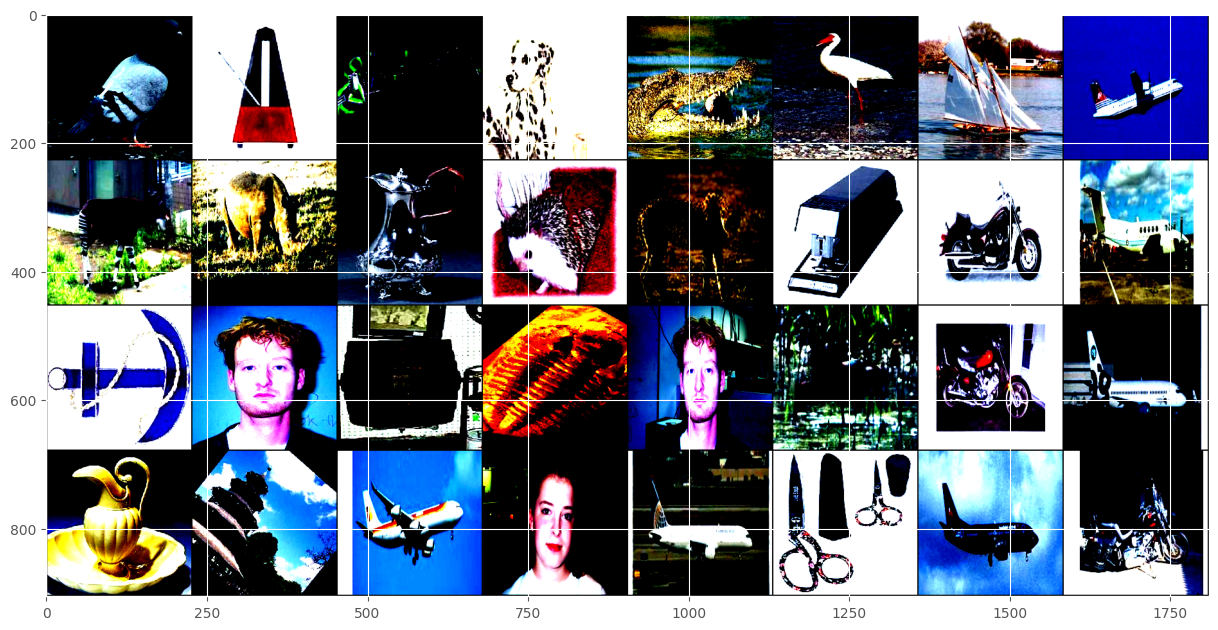

In [ ]:
def imshow(img):
    plt.figure(figsize=(15, 12))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
class ResNet34(nn.Module):
    def __init__(self, pretrained):
        super(ResNet34, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__['resnet34'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['resnet34'](pretrained=None)
        
        # change the classification layer
        self.l0 = nn.Linear(512, len(lb.classes_))
        self.dropout = nn.Dropout2d(0.4)
    def forward(self, x):
        # get the batch size only, ignore (c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        x = self.dropout(x)
        l0 = self.l0(x)
        return l0
#model = ResNet34(pretrained=True).to(device)

In [ ]:
from torch.nn.modules.batchnorm import BatchNorm1d

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()

        self.layer = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding=1), # 224*224*16
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 112 * 112 * 16
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding=1), # 112 * 112 * 32
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 56 * 56 * 32            
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3,padding=1), # 56 * 56 * 64
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 28 * 28 * 64
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1), # 28 * 28 * 128
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 256,  kernel_size = 3, padding = 1), # 28 * 28 * 256
            nn.ReLU(),
            nn.MaxPool2d(2,2), # #14 * 14 * 256
        )

        self.fc_layer = nn.Sequential(  
            nn.Linear(14 * 14 * 256, 3136),
            nn.BatchNorm1d(3136),
            #nn.Linear(294, 101),
            nn.Dropout1d(0.4),
            nn.Linear(3136, 1568),
            #nn.BatchNorm1d(1568),
            #nn.Linear(1568, 101),

            )
        
            #relu
            #linear
            #dropout을 여기계층에다가
        
    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        return out

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = ResNet34(pretrained=True).to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
def train(model, dataloader):
    model.train() #train 모드로 해주고,
    train_running_loss = 0.0 # 여기다가 다 쌓아가는 느낌으로다가.
    train_running_correct = 0 #

    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)  # 0번 인덱스가 data, 1번 인덱스가 target
        optimizer.zero_grad()
        outputs = model(data)
        loss = loss_func(outputs, torch.max(target, 1)[1])
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / len(dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    
    return train_loss, train_accuracy

In [ ]:

def validate(model, dataloader):
    model.eval() #validation 모드로 바꿔주고

    val_running_loss = 0.0
    val_running_correct = 0
    
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)): #tqdm쓰면 epoch 돌 때 진행률 보임.
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = loss_func(outputs, torch.max(target, 1)[1])
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        
        val_loss = val_running_loss/len(dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(dataloader.dataset)
        
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        
        return val_loss, val_accuracy

In [ ]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []

start = time.time()
for epoch in range(num_epoch):
    print(f"Epoch {epoch+1} of {num_epoch}")
    train_epoch_loss, train_epoch_accuracy = train(model, train_loader) # train
    val_epoch_loss, val_epoch_accuracy = validate(model, val_loader) # validate
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()

print((end-start) / 60, 'minutes')

Epoch 1 of 5


  0%|          | 0/162 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
100%|██████████| 162/162 [00:34<00:00,  4.72it/s]


Train Loss: 0.0575, Train Acc: 63.92


100%|██████████| 54/54 [00:06<00:00,  8.29it/s]


Val Loss: 0.0162, Val Acc: 89.98
Epoch 2 of 5


100%|██████████| 162/162 [00:24<00:00,  6.59it/s]


Train Loss: 0.0095, Train Acc: 95.62


100%|██████████| 54/54 [00:06<00:00,  8.86it/s]


Val Loss: 0.0074, Val Acc: 94.76
Epoch 3 of 5


100%|██████████| 162/162 [00:25<00:00,  6.45it/s]


Train Loss: 0.0026, Train Acc: 98.94


100%|██████████| 54/54 [00:06<00:00,  8.31it/s]


Val Loss: 0.0057, Val Acc: 95.74
Epoch 4 of 5


100%|██████████| 162/162 [00:25<00:00,  6.34it/s]


Train Loss: 0.0013, Train Acc: 99.29


100%|██████████| 54/54 [00:06<00:00,  8.49it/s]


Val Loss: 0.0054, Val Acc: 95.62
Epoch 5 of 5


100%|██████████| 162/162 [00:25<00:00,  6.41it/s]


Train Loss: 0.0008, Train Acc: 99.39


100%|██████████| 54/54 [00:06<00:00,  8.95it/s]

Val Loss: 0.0050, Val Acc: 96.26
2.774612820148468 minutes


In [ ]:
torch.save(model.state_dict(), f"model_{num_epoch}.pth") # .pth로 파일 저장.

[63.919308357348704, 95.61959654178675, 98.9433237271854, 99.28914505283382, 99.38520653218059]
[0.05745597822407366, 0.009492780249583733, 0.0026068188539928937, 0.001258708395629291, 0.0007720083372236214]
[89.97695852534562, 94.75806451612904, 95.73732718894009, 95.6221198156682, 96.2557603686636]
[0.01616078441799511, 0.007447815723373868, 0.005657905786757439, 0.005358035176185556, 0.005039102883906477]


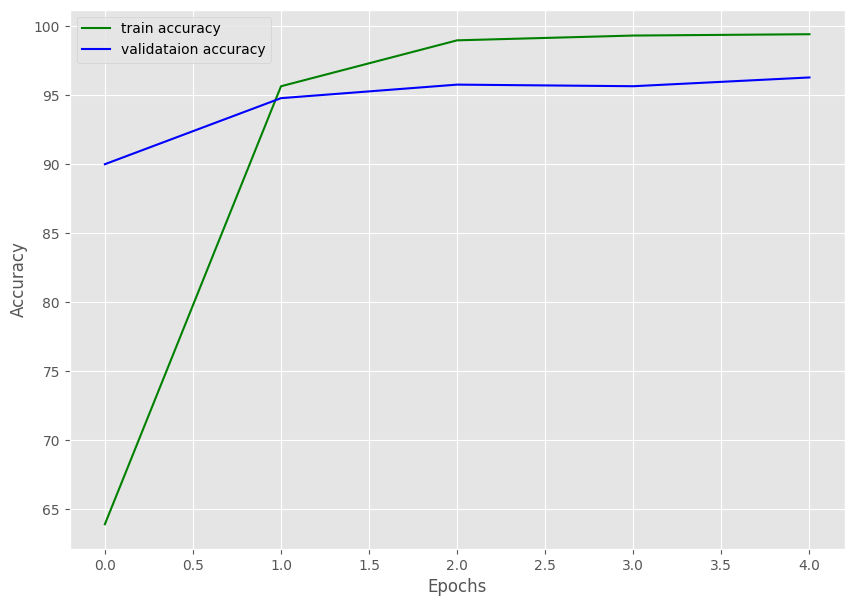

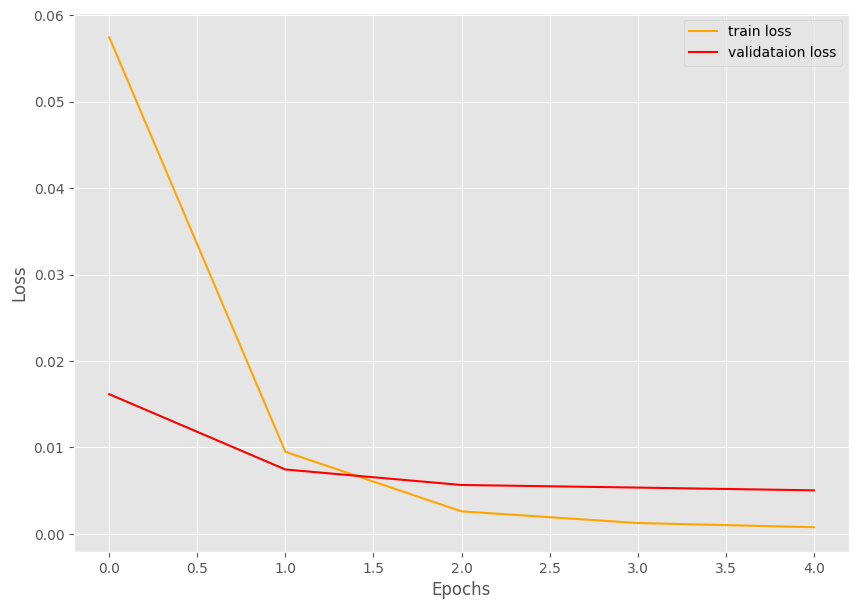

['val_loss.pkl']

In [ ]:
print(train_accuracy)
print(train_loss)
print(val_accuracy)
print(val_loss)

# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

import joblib
joblib.dump(train_accuracy, 'train_accuracy.pkl') #이 받아온 데이터를 저장 가능. joblib.dump로.
joblib.dump(train_loss, 'train_loss.pkl')
joblib.dump(val_accuracy, 'val_accuracy.pkl')
joblib.dump(val_loss, 'val_loss.pkl')


#여기까지 오버피팅 빠졌는지, 정확도 최대로 올렸는지 확인하는 것이고, 

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs = data[0].to(device, non_blocking=True)
        target = data[1].to(device, non_blocking=True)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == torch.max(target, 1)[1]).sum().item()

print('Accuracy of the network on test images: %0.3f %%' % (100 * correct / total))

Accuracy of the network on test images: 96.296 %


In [ ]:
# 1st: 35,  2nd: 44 , 3nd: 40